<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/01_ARIMA.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARIMA Model

The ARIMA model is short for the Autoregressive (AR), Integrated (I) Moving Average (MA) model.
This model uses 3 processes:

*   The AR process, based on autocorrelations between past and
present values
*   The integrating (I) process. Integrating is a more mathematical synonym
for differencing a non-stationary time series. In ARIMA, this differencing is not anymore
done in advance of the modeling phase, but it is done during the model fit.
*   The MA process, based on correlations between past errors and
present values


The linear trend is a good example to try this model. More specifically, the values will not be stationary at all: they will
augment (or diminish) infinitely. Yet the difference between each value and the next is constant, so the
differenced time series is perfectly stationary.

The fact that the differencing is part of the hyperparameters has a great added value for
model building. This makes it possible to do automated hyperparameter tuning on the
number of times that differencing should be applied. In this example, data are weekly CO2 data that are available through the
statsmodels library.



#### 1 - Importing Data

Data: Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.

Period of Record: March 1958 - December 2001

Number of observations: 2225
Number of variables: 2
Variable name definitions:

1.   date - sample date in YYMMDD format
2.   co2 - CO2 Concentration in  ppmv


The data returned by load_pandas contains the dates as the index.

Source: https://www.statsmodels.org/devel/datasets/generated/co2.html

In [3]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas()
data = data.data
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


#### 2 - Plotting Data

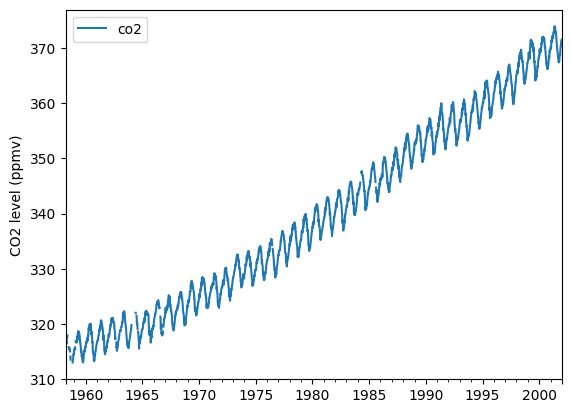

In [4]:
import matplotlib.pyplot as plt
ax = data.plot()
ax.set_ylabel('CO2 level (ppmv)')
plt.show()

This data shows a very obvious sign of an upward trend, which is fairly constant. And
there is also a very clear seasonality pattern in this data (up and down).
Then, we should look at its autocorrelation and partial autocorrelation functions. However, both autocorrelation (ACF) and partial autocorrelation (PACF) plots are relevant only when applied to stationary data.
For this reason, in the next section we will plot ACF and PACF on the differenced data


#### 3 - ACF and PACF plots

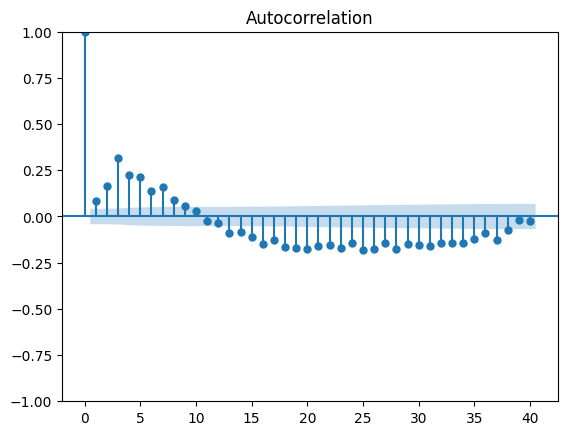

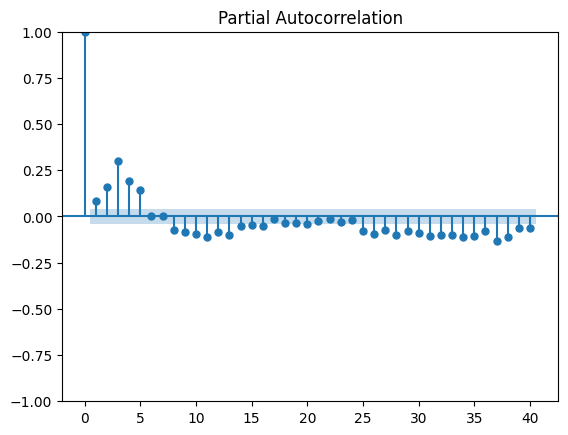

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data.diff().dropna(), lags=40)
plot_pacf(data.diff().dropna(), lags=40)
plt.show()

In general, if there is no decay of the correlations toward zero, this means the data is not stationary. In this case, data has been differenced and seems stationary. However, the decay occurs relatively late in the autocorrelation. For this reason, we can increase the number of lags and see both plots again

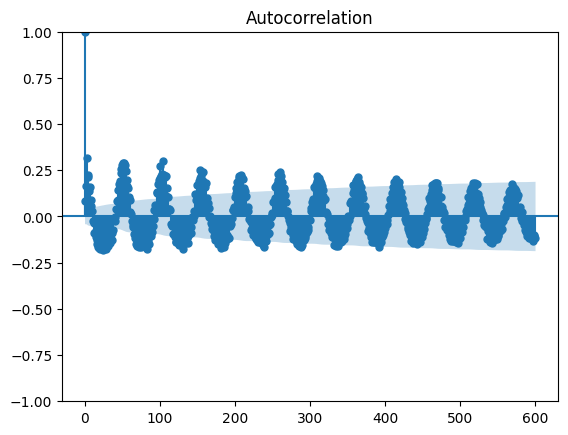

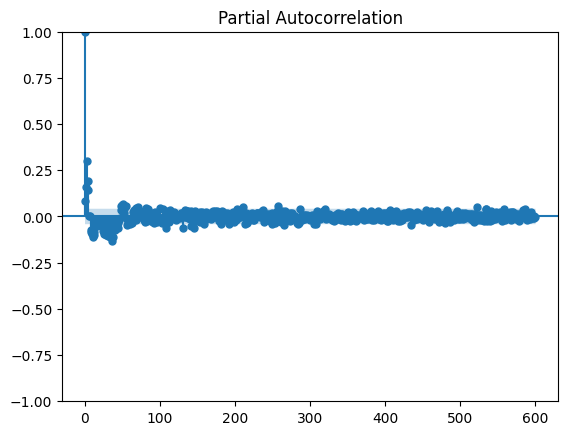

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data.diff().dropna(), lags=600)
plot_pacf(data.diff().dropna(), lags=600)
plt.show()

Spiegare come questo influisce nella scelta dell'iperparametro I

#### 4 - Hyperparameter tuning

The ARIMA(p,I,q) model has three hyperparameters:


*   The order of the AR process denoted by p
*   The order of the MA process denoted by q
*   The order of integration denoted by I




In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
data_array = data[['co2']].values
avg_errors = []
for p in range(6):
  for q in range(6):
    for i in range(3):
      errors = []
      tscv = TimeSeriesSplit(test_size=10)
      for train_index, test_index in tscv.split(data_array):
        X_train, X_test = data_array[train_index], data_array[test_index]
        X_test_orig = X_test
        fcst = []
        for step in range(10):
          try:
            mod = ARIMA(X_train, order=(p,i,q))
            res = mod.fit()
            fcst.append(res.forecast(steps=1))
          except:
            print('errorred')
            fcst.append(-9999999.)
        X_train = np.concatenate((X_train, X_test[0:1,:]))
        X_test = X_test[1:]
      errors.append(r2_score(X_test_orig, fcst))

  pq_result = [p, i, q, np.mean(errors)]
  print(pq_result)
  avg_errors.append(pq_result)

  avg_errors = pd.DataFrame(avg_errors)
  avg_errors.columns = ['p', 'i', 'q', 'error']
  avg_errors.sort_values('error', ascending=False)

#### 5 - Best forecast result

In [ ]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
data_array = data[['co2']].values
X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = X_test
fcst = []
for step in range(10):
  mod = ARIMA(X_train, order=(4,1,4))
  res = mod.fit()
  fcst.append(res.forecast(steps=1))
  X_train = np.concatenate((X_train, X_test[0:1,:]))
  X_test = X_test[1:]

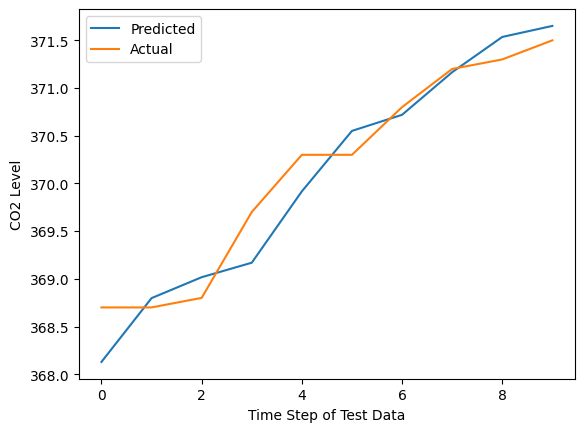

In [9]:
plt.plot(fcst)
plt.plot(X_test_orig)
plt.legend(['Predicted', 'Actual'])
plt.ylabel('CO2 Level')
plt.xlabel('Time Step of Test Data')
plt.show()